# Assignment #5

## PART 1 [60 points] Play with the CNN

Change the CNN in deepLearning_4.ipynb such that it will classify faces versus non-faces using the uploaded python pickle files. 

When you submit your assignment DO NOT submit these files, just assume that they live in '../data/'!!!!

Play with number of layers and number of filters to find the network architecture that will solve this task with the best accuracy given 10 epochs of training [not more epochs]. 

Comment your results and tell me about your findings.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import cv2

# for seed
import os 
import random
import sys

import pickle

In [2]:
print('opencv version: ',cv2.__version__)
print('pytorch version: ',torch.__version__)

opencv version:  4.5.1
pytorch version:  1.8.0+cu111


# Random Seed

In [3]:
def torch_seed(random_seed: int = 223):
    """
    set deterministic seed

    Argument
    --------
    - random_seed : random seed number, default 223 is my birth day. haha

    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Configuration

In [4]:
class Config:
    batch_size = 8 # how many images to load each time the dataloader is called
    train_ratio = 0.7 # train-test split ratio
    epochs = 10
    doGPU = True
    datadir = '../data'

In [5]:
config = Config()

In [6]:
if (config.doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load CIFAR10 and FaceData

In [7]:
# this will take care of image normalization
# we do this so that all images have a "good" data range
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0,5)])

# load cifar10 
cifar10_trainset = torchvision.datasets.CIFAR10(root=config.datadir, train=True,
                                        download=True)
cifar10_testset = torchvision.datasets.CIFAR10(root=config.datadir, train=False,
                                       download=True)

# load facedata
facedata = pickle.load(open(f'{config.datadir}/faces_python.pkl','rb'))
facedata = facedata.astype(np.float32)
facedata = facedata.reshape(facedata.shape[0],32,32,1)

# define classes
classes = ['Not Face','Face']

Files already downloaded and verified
Files already downloaded and verified


## Split Facedata into train and test

In [8]:
torch_seed(223) # 223 is jaehyuk's birthday

nb_facedata = facedata.shape[0]
nb_train = int(nb_facedata * config.train_ratio)

print('The number of train face data: ',nb_train)
print('The number of test face data: ',nb_facedata - nb_train)

facedata_idx = np.arange(nb_facedata)

# random shuffle
np.random.shuffle(facedata_idx)

# split train and test
train_facedata = facedata[:nb_train]
test_facedata = facedata[nb_train:]
print('train face data shape: ',train_facedata.shape)
print('test face data shape: ',test_facedata.shape)

The number of train face data:  9263
The number of test face data:  3970
train face data shape:  (9263, 32, 32, 1)
test face data shape:  (3970, 32, 32, 1)


## Concatenate CIFAR10 and FaceData

In [9]:
def rgb2gray(rgb):
    
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return np.expand_dims(gray, axis=-1).astype(np.float32)

# convert rgb to gray 

train_cifar10data = rgb2gray(cifar10_trainset.data)
test_cifar10data = rgb2gray(cifar10_testset.data)

print('train CIFAR10 data shape: ',train_cifar10data.shape)
print('test CIFAR10 data shape: ',test_cifar10data.shape)

train CIFAR10 data shape:  (50000, 32, 32, 1)
test CIFAR10 data shape:  (10000, 32, 32, 1)


In [10]:
torch_seed(223) # 223 is jaehyuk's birthday

# concatenate CIFAR10 and Face images
train_data = np.vstack([train_facedata, train_cifar10data])
test_data = np.vstack([test_facedata, test_cifar10data])

print('total train data shape: ',train_data.shape)
print('total test data shape: ',test_data.shape)

# train shuffle
train_idx = np.arange(train_data.shape[0])
np.random.shuffle(train_idx)
train_data = train_data[train_idx]

# test shuffle
test_idx = np.arange(test_data.shape[0])
np.random.shuffle(test_idx)
test_data = test_data[test_idx]

# targets
train_targets = np.hstack([np.ones(train_facedata.shape[0]), np.zeros(train_cifar10data.shape[0])])[train_idx]
test_targets = np.hstack([np.ones(test_facedata.shape[0]), np.zeros(test_cifar10data.shape[0])])[test_idx]
print('total train target shape: ',train_targets.shape)
print('total test target shape: ',test_targets.shape)

total train data shape:  (59263, 32, 32, 1)
total test data shape:  (13970, 32, 32, 1)
total train target shape:  (59263,)
total test target shape:  (13970,)


# Build Dataset and DataLoader

In [11]:
class NewDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        super(NewDataset, self).__init__()
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.targets[idx]

        if self.transform:
            data = self.transform(data)
        
        return data, target

In [12]:
trainset = NewDataset(data=train_data, 
                      targets=train_targets, 
                      transform=transform)
testset = NewDataset(data=test_data, 
                     targets=test_targets, 
                     transform=transform)

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=config.batch_size,
                                          shuffle=True,
                                          num_workers=4)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=config.batch_size,
                                         shuffle=False,
                                         num_workers=4)

## Show Images

In [14]:
images, targets = next(iter(trainloader))

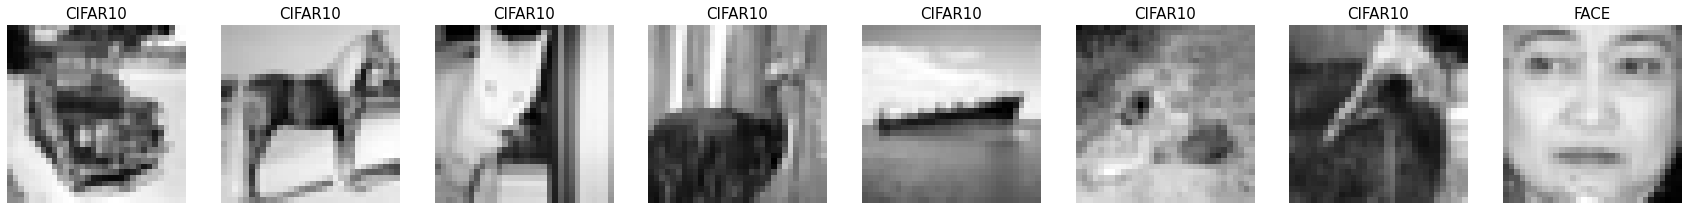

In [15]:
f, ax = plt.subplots(1, config.batch_size, figsize=(30,5))
for i in range(images.shape[0]):
    ax[i].imshow(images[i].squeeze().numpy(), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title('CIFAR10' if targets[i] == 0 else 'FACE', size=15)

# Build Model

In [17]:
# defines a small CNN based on the nn.Module class
class CNN(nn.Module):
    # every nn needs the constructor
    def __init__(self, conv_channel_lst, fc_feature_lst):
        # call the pytorch constructor of the parent class
        super().__init__()
        
        self.nb_conv = len(conv_channel_lst)
        
        # Conv layer
        self.conv_lst = nn.Sequential()
        for i in range(len(conv_channel_lst)):
            if i == 0:
                self.conv_lst.add_module(f"conv{i}", nn.Conv2d(1, conv_channel_lst[i], 3))
            else:
                self.conv_lst.add_module(f"conv{i}", nn.Conv2d(conv_channel_lst[i-1], conv_channel_lst[i], 3))
            self.conv_lst.add_module(f"maxpool{i}", nn.MaxPool2d(2, 2))
            self.conv_lst.add_module(f"relu{i}", nn.ReLU())
        
        
        # fully connected layer [the 32*5*5 needs to calculated]
        output_dim = self.calc_fcn_layer()
        self.fc_lst = nn.Sequential()
        for i in range(len(fc_feature_lst)):
            if i == 0:
                self.fc_lst.add_module(f"fcn{i}", nn.Linear(conv_channel_lst[-1] * output_dim * output_dim, fc_feature_lst[i]))
            else:
                self.fc_lst.add_module(f"fcn{i}", nn.Linear(fc_feature_lst[i-1], fc_feature_lst[i]))
            if i != len(fc_feature_lst)-1:
                self.fc_lst.add_module(f"relu{i}", nn.ReLU())
        
    # every nn needs a forward pass function which takes data x
    # as input and returns x as output
    # the forward function uses the layers defined in the 
    # constructor to make the network architecture
    def forward(self, x):
        # conv layers
        x = self.conv_lst(x)
        
        # flatten output so that it fits into fc layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # fc layers
        x = self.fc_lst(x)
        return x
    
    def calc_fcn_layer(self):
        input_dim = 32
        k = 3 # kernel size
        s = 1 # strides
        p = 0 # padding size
        
        for i in range(self.nb_conv):
            input_dim = (input_dim - k + 2*p)/s + 1
            input_dim = int(input_dim/2) # max pooling with kernel size 2 and strides 2
        
        return input_dim

# Experiments

We conducted a total of 10 experiments by changing the number of layers, channels, and Fc layers of the CNN, and the number of features.

In [18]:
experiments = {
    'exp0':{
        'conv_channel_lst':[16],
        'fc_feature_lst':[2]
    },
    'exp1':{
        'conv_channel_lst':[16,32],
        'fc_feature_lst':[2]
    },
    'exp2':{
        'conv_channel_lst':[16,32,64],
        'fc_feature_lst':[2]
    },
    'exp3':{
        'conv_channel_lst':[16,32],
        'fc_feature_lst':[128, 2]
    },
    'exp4':{
        'conv_channel_lst':[16,32],
        'fc_feature_lst':[128, 64, 2]
    },
    'exp5':{
        'conv_channel_lst':[32,64],
        'fc_feature_lst':[2]
    },
    'exp6':{
        'conv_channel_lst':[32,64],
        'fc_feature_lst':[128, 2]
    },
    'exp7':{
        'conv_channel_lst':[32,64],
        'fc_feature_lst':[128, 64, 2]
    },
    'exp8':{
        'conv_channel_lst':[64,128],
        'fc_feature_lst':[2]
    },
    'exp9':{
        'conv_channel_lst':[64,128],
        'fc_feature_lst':[128, 2]
    },
    'exp10':{
        'conv_channel_lst':[64,128],
        'fc_feature_lst':[128, 64, 2]
    },
}

# Training and Test

In [19]:
def fit(trainloader, epochs, model, criterion, optimizer, device):
    history = {'acc':[], 'loss':[]}
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total_correct = 0
        total_cnt = 0
        # load a batch of data
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + loss + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Correct
            _, pred = outputs.max(1)
            total_correct += labels.eq(pred).sum().item()
            total_cnt += labels.size(0)

            # print statistics
            running_loss += loss.item()

            if i == len(trainloader)-1:
                print()
            else:
                sys.stdout.write(f'\rEpoch [{epoch+1}/{epochs}] | Step [{i+1}/{len(trainloader)}] ' \
                                 f'Loss: {running_loss/(i+1):.4f} Acc: {total_correct/total_cnt:.2%} [{total_correct}/{total_cnt}]')


        # save history
        history['acc'].append(total_correct / total_cnt)
        history['loss'].append(running_loss / len(trainloader))

    print('Finished Training')
    
    return history

In [20]:
def inference(testloader, batch_size, classes, device):
    # prepare to count predictions for each class
    correct_pred = {'Face': 0, 'Not Face': 0}
    total_pred = {'Face': 0, 'Not Face': 0}

    # this will hold all activations for all classes for 
    # later plotting of confusion matrix
    full_pred = np.empty((len(testloader)*config.batch_size, 2))
    # again no gradients needed
    with torch.no_grad():
        # go through all elements in the test set
        for i,data in enumerate(testloader):
            # again push them to device
            inputs, labels = data[0].to(device), data[1].to(device)
            # we need the forward pass
            outputs = net(inputs)
            # and store for later use
            full_pred[i*labels.size(0):i*labels.size(0)+labels.size(0),:]=outputs.cpu().numpy()

            # the predicted class is the maximum across the
            # batch for the second dimension
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                             accuracy))
        
    return full_pred

We performed a total of 10 experiments using SGD as the optimizer and cross entropy as the loss function.

In [21]:
torch_seed(223) # 223 is jaehyuk's birthday

exp_info = {exp_no: {} for exp_no in experiments.keys()}
for exp_no, exp in experiments.items():
    print(f'[EXPERIMENT] {exp_no}')
    # define model
    net = CNN(**exp).to(device)
    print('The number of Model Parameteres: ',np.sum([np.prod(param.size()) for param in net.parameters()]))
    
    # define the loss - typically, classification is trained with
    # the cross entropy loss
    criterion = nn.CrossEntropyLoss()
    # define the optimizer that will train the network for us
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    # model train
    history = fit(trainloader=trainloader,
              epochs=config.epochs,
              model=net,
              criterion=criterion,
              optimizer=optimizer,
              device=device)
    
    # inference
    full_pred = inference(testloader=testloader, 
                          batch_size=config.batch_size,
                          classes=classes,
                          device=device)
    
    exp_info[exp_no]['history'] = history
    exp_info[exp_no]['pred'] = full_pred
    print()

[EXPERIMENT] exp0
The number of Model Parameteres:  7362
Epoch [1/10] | Step [7407/7408] Loss: 0.0035 Acc: 99.94% [59223/59256]
Epoch [2/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [3/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [4/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [5/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [6/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [7/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [8/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [9/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [10/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Finished Training
Accuracy for class Face  is: 100.0 %
Accuracy for class Not Face is: 100.0 %

[EXPERIMENT] exp1
The number of Model Parameteres:  7106
Epoch [1/10] | Step [7407/7408] Loss: 0.0041 Acc: 99.92% [59209/59256]

Epoch [4/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [5/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [6/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [7/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [8/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [9/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [10/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Finished Training
Accuracy for class Face  is: 100.0 %
Accuracy for class Not Face is: 100.0 %

[EXPERIMENT] exp10
The number of Model Parameteres:  672834
Epoch [1/10] | Step [7407/7408] Loss: 0.0096 Acc: 99.91% [59203/59256]
Epoch [2/10] | Step [7407/7408] Loss: 0.0001 Acc: 100.00% [59256/59256]
Epoch [3/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [4/10] | Step [7407/7408] Loss: 0.0000 Acc: 100.00% [59256/59256]
Epoch [5/10] | Step [7407/7408] Loss: 0.0000 Acc: 10

In all 10 experiments, the loss converged to 0 during training, and both face images and non-face images were classified 100% during inference.

## History

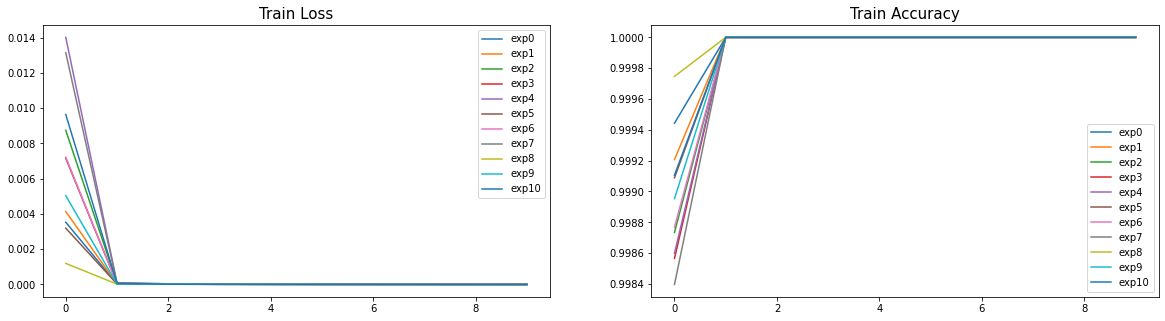

In [22]:
f, ax = plt.subplots(1, 2, figsize=(20,5))
for idx, info in enumerate(exp_info.values()):
    ax[0].plot(info['history']['loss'])
    ax[1].plot(info['history']['acc'])

ax[0].set_title('Train Loss', size=15)
ax[1].set_title('Train Accuracy', size=15)
ax[0].legend(list(exp_info.keys()))
ax[1].legend(list(exp_info.keys()))

# Evaluation

In [23]:
import itertools
# function to plot confusion matrix
# adapted from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(full_pred, testset, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # make confusion matrix
    cm = np.zeros((len(classes),len(classes)))
    # the true labels
    tr = testset.targets
    # the predicted labels
    pr = full_pred.argmax(axis=1)
    # add for each pair
    for i in range(len(testset.targets)):
        cm[tr[i],pr[i]]+=1
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = '{}\nAccuracy: {:.2f}'.format(
            title,np.mean(np.diag(cm)))

    #print(cm)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=15)
    cbar = plt.colorbar()
    # this is needed to adjust the small ticklabels on the colorbar
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    # show the x and y ticks with nice rotation if needed
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    # adjust threshold for black / white font
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=15
                )

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    

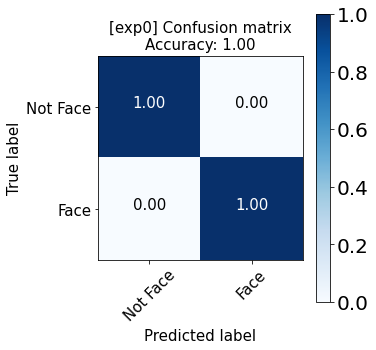

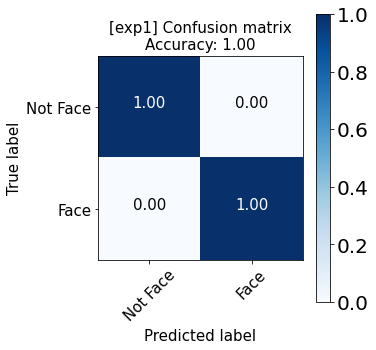

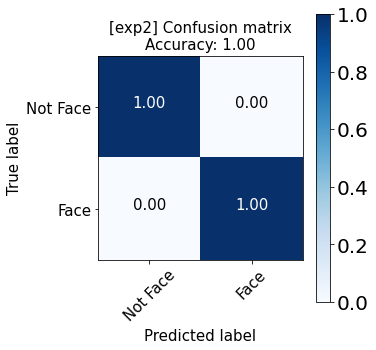

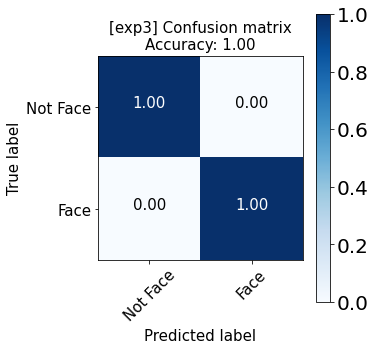

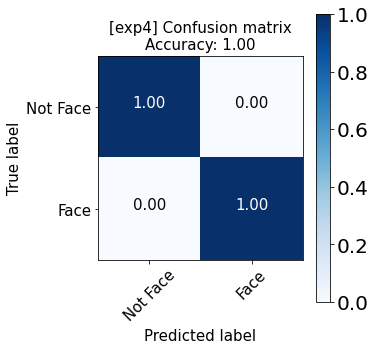

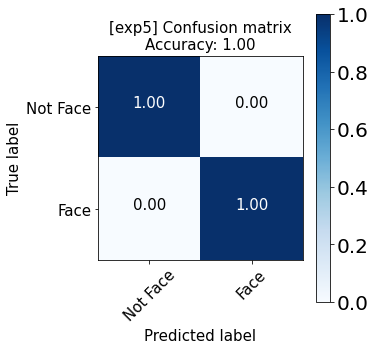

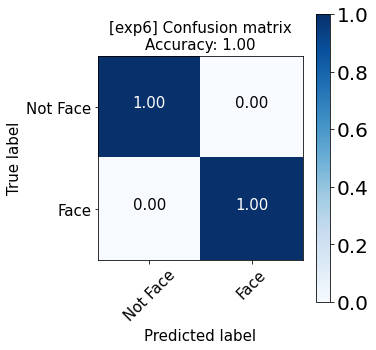

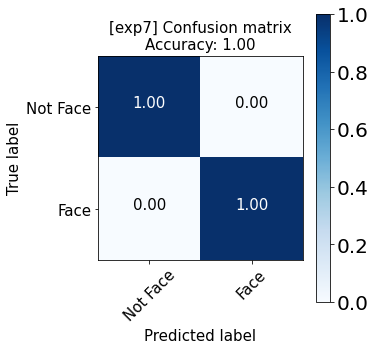

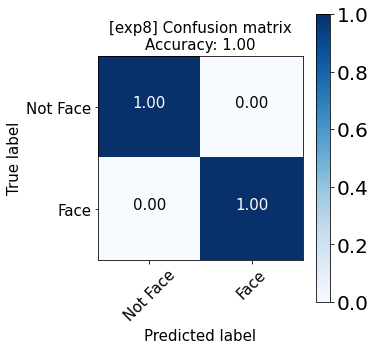

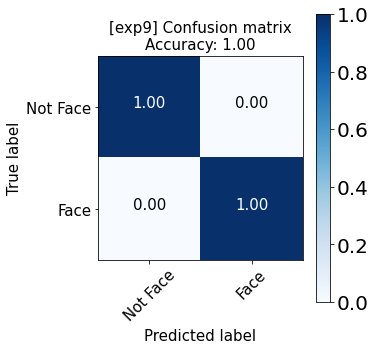

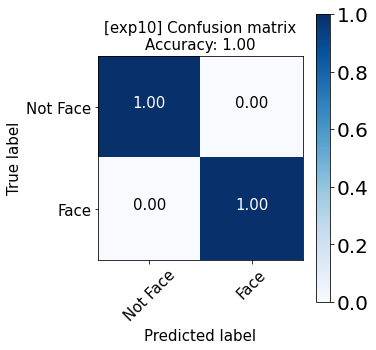

In [24]:
for exp_no, info in exp_info.items():
    plot_confusion_matrix(info['pred'], testset, classes, title=f'[{exp_no}] Confusion matrix', normalize=True)

only visualized 25 of them.

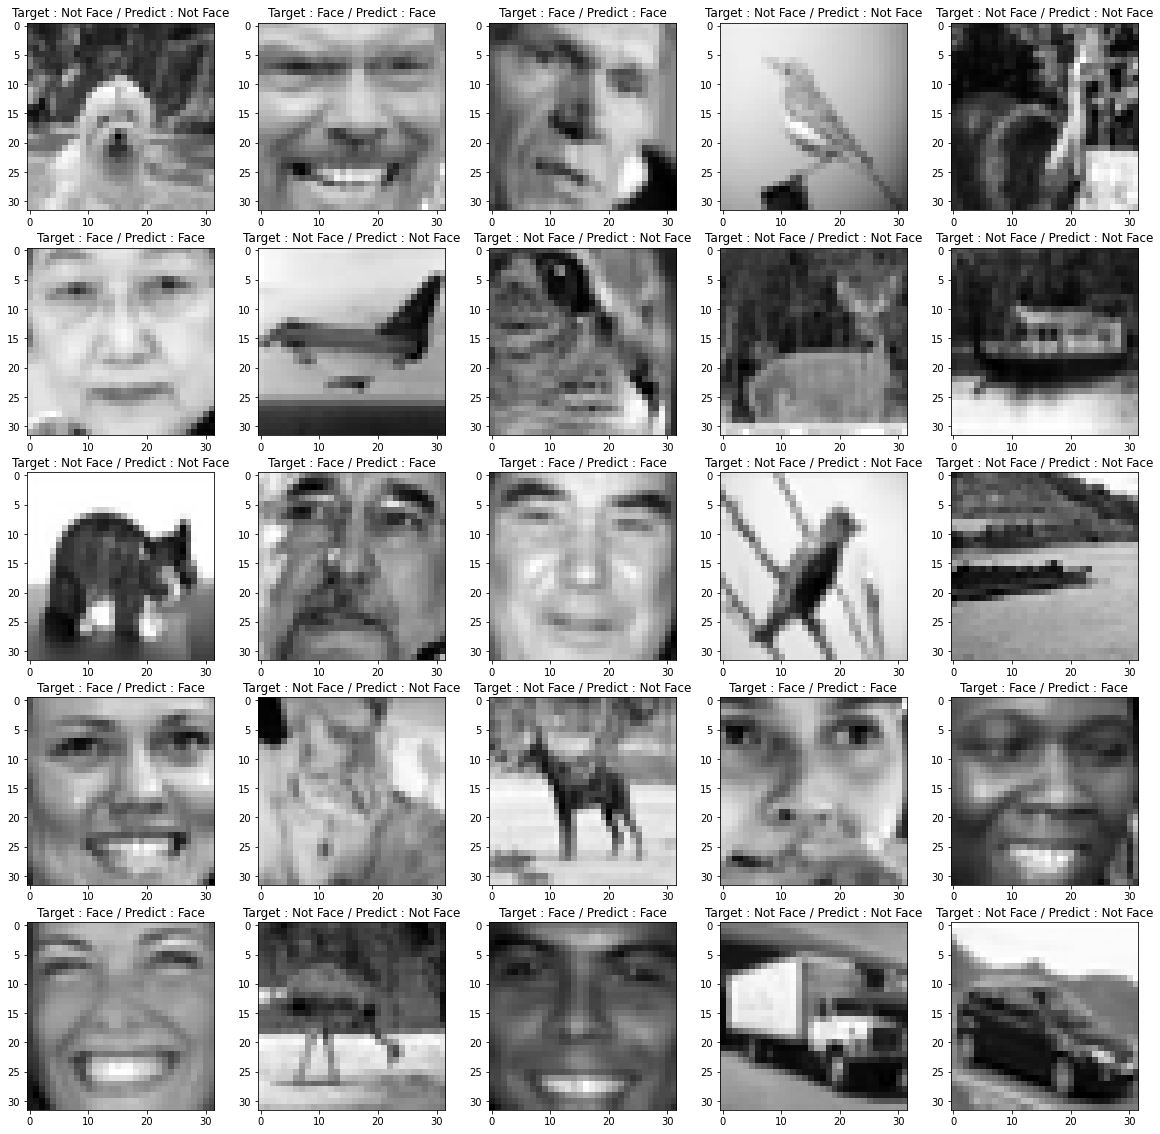

In [43]:
plt.figure(figsize=(20, 20))
with torch.no_grad():
    for i in range(25):
        plt.subplot(5, 5, i+1)
        data = testset[i]
        inputs, labels = data[0].to(device).unsqueeze(0), data[1].to(device)
        outputs = net(inputs).cpu()
        _, predictions = torch.max(outputs, 1)
        
        plt.imshow(data[0].squeeze().numpy(), cmap='gray')
        plt.title(f'Target : {classes[labels]} / Predict : {classes[predictions]}')
        
plt.show()

# Conclusion

We conducted a total of 10 experiments, and all 10 were trained to achieve an accuracy of 100. Both face images and non-face images were classified 100% in the inference stage, and it was confirmed that they were classified well when checked in the evaluation stage.

---